<a href="https://colab.research.google.com/github/vaibhavtiwari33/cancer-detect/blob/main/cancer-detect.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from fastai.vision import *
from fastai.metrics import error_rate

# Import Libraries here
import os
import json 
import shutil
import zipfile

%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import *
import pandas as pd

In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


# Load Kaggle Data

In [ ]:
!pip install --upgrade --force-reinstall --no-deps kaggle

     |████████████████████████████████| 61kB 2.4MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.12-cp37-none-any.whl size=73053 sha256=aabb8654eae694450fdd46a36555e01fcf9db8979f81c9a189f162f09ea7fc68
  Stored in directory: /root/.cache/pip/wheels/a1/6a/26/d30b7499ff85a4a4593377a87ecf55f7d08af42f0de9b60303
Successfully built kaggle
  Found existing installation: kaggle 1.5.12
    Uninstalling kaggle-1.5.12:
      Successfully uninstalled kaggle-1.5.12


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#base_dir = 'drive/MyDrive/Documents/Project/ECE228'
base_dir = 'drive/MyDrive/UCSD/ECE228'
Path(base_dir).ls()

[PosixPath('drive/MyDrive/UCSD/ECE228/histopathologic-cancer-detection.zip')]

In [ ]:
#!kaggle competitions download -c histopathologic-cancer-detection -p "{base_dir}"

100% 6.31G/6.31G [01:33<00:00, 52.1MB/s]
100% 6.31G/6.31G [01:36<00:00, 70.5MB/s]


In [ ]:
import subprocess
subprocess.call(['unzip', '{}/histopathologic-cancer-detection.zip'.format(base_dir)])

0

# Transfer data for flow_from_directory call

In [ ]:
from shutil import copyfile

In [ ]:
folders = ['train', 'test']
labels = ['0', '1']

In [ ]:
!mv sample_submission.csv test_labels.csv

In [ ]:
!mkdir -p "dataset_folder/test/0"
!mkdir -p "dataset_folder/test/1"
!mkdir -p "dataset_folder/train/0"
!mkdir -p "dataset_folder/train/1"

In [ ]:
for folder in folders:
    df = pd.read_csv('{}_labels.csv'.format(folder))
    for filename, label in zip(df['id'], df['label']):
        copyfile('{}/{}.tif'.format(folder, filename), 
                 '{}/{}/{}/{}.tif'.format('dataset_folder', folder, label, filename))

In [ ]:
!rm -rf test
!rm -rf train

# Reference Notebook Code

In [ ]:
tfms = get_transforms(do_flip=True)

In [ ]:
bs=64 # also the default batch size
data = ImageDataBunch.from_csv('.',
    ds_tfms=tfms, 
    size=224, 
    suffix=".tif",
    folder="train", 
    test="test",
    csv_labels="train_labels.csv", 
    bs=bs)

In [ ]:
data.normalize(imagenet_stats)

ImageDataBunch;

Train: LabelList (176020 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
0,1,0,0,0
Path: .;

Valid: LabelList (44005 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
0,1,0,0,1
Path: .;

Test: LabelList (57458 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: EmptyLabelList
,,,,
Path: .

In [ ]:
data.one_batch()

In [ ]:
data

ImageDataBunch;

Train: LabelList (176020 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
0,0,0,0,0
Path: .;

Valid: LabelList (44005 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
1,0,0,1,0
Path: .;

Test: LabelList (57458 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: EmptyLabelList
,,,,
Path: .

In [ ]:
learn = cnn_learner(data, models.resnet50, metrics=error_rate, callback_fns=ShowGraph)#.to_fp16()

In [ ]:
learn.summary

In [ ]:
!pip install onnx

     |████████████████████████████████| 12.2MB 5.4MB/s 


In [ ]:
!pip install tensorflow-addons

     |████████████████████████████████| 686kB 6.8MB/s 


In [ ]:
!pip install git+https://github.com/onnx/onnx-tensorflow.git

  Cloning https://github.com/onnx/onnx-tensorflow.git to /tmp/pip-req-build-zbslp0t_
  Running command git clone -q https://github.com/onnx/onnx-tensorflow.git /tmp/pip-req-build-zbslp0t_
  Created wheel for onnx-tf: filename=onnx_tf-1.8.0-cp37-none-any.whl size=219689 sha256=962d0117318f694d5b1313c686fa53628529c1385e09e7468a49f75d8335b01a
  Stored in directory: /tmp/pip-ephem-wheel-cache-mac_r0q4/wheels/54/24/31/8873b33d2d560efdfa1ed6f346df67ef793b1897358705a480
Successfully built onnx-tf


In [ ]:
!git clone https://github.com/onnx/onnx-tensorflow.git && cd onnx-tensorflow && pip install -e .

Cloning into 'onnx-tensorflow'...
remote: Enumerating objects: 6136, done.
remote: Counting objects: 100% (85/85), done.
remote: Compressing objects: 100% (66/66), done.
remote: Total 6136 (delta 45), reused 33 (delta 18), pack-reused 6051
Receiving objects: 100% (6136/6136), 1.87 MiB | 13.13 MiB/s, done.
Resolving deltas: 100% (4770/4770), done.
Obtaining file:///content/onnx-tensorflow
  Found existing installation: onnx-tf 1.8.0
    Can't uninstall 'onnx-tf'. No files were found to uninstall.
  Running setup.py develop for onnx-tf


In [ ]:
%cd onnx-tensorflow/

/content/onnx-tensorflow


[autoreload of onnx_tf failed: Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/IPython/extensions/autoreload.py", line 247, in check
    superreload(m, reload, self.old_objects)
ModuleNotFoundError: spec not found for the module 'onnx_tf'
]


In [ ]:
from torch.autograd import Variable
import onnx
import onnx_tf
from onnx_tf.backend import prepare

In [ ]:
dummy_input = Variable(torch.randn(1, 3, 224, 224))
torch.onnx.export(learn.model, dummy_input, "/content/dummy.onnx", input_names=['test_input'], output_names=['test_output'])

In [ ]:
tf_rep = prepare(onnx.load('/content/dummy.onnx'))

In [ ]:
tf_rep.export_graph('/content/dummy_model')

INFO:tensorflow:Assets written to: /content/dummy_model/assets


INFO:tensorflow:Assets written to: /content/dummy_model/assets


In [ ]:
converted_model = tf.keras.models.load_model('/content/dummy_model')

In [ ]:
type(converted_model)

tensorflow.python.saved_model.load.Loader._recreate_base_user_object.<locals>._UserObject

# Data Augmentation

### TODO: 
 * Fit generator on input sample (done with preprocessing function)
 * Apply learned params to test data (create another generator for test and apply same preprocessing function)

In [ ]:
new_base_dir = 'dataset_folder'
training_sub_path = 'train'
test_sub_path = 'test'

In [ ]:
#IMG_SIZE = (96, 96)
"""
Images in the target PCam dataset are square images 96x96. 
However, when bringing a pre-trained ImageNet model into our
network, which was trained on larger images, we need to set
the size accordingly to respect the image sizes in that dataset.
"""
IMG_SIZE = (96, 96) 
IMG_SHAPE = IMG_SIZE + (3,)
BATCH_SIZE = 64

In [ ]:
imagenet_stats

([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

In [ ]:
def add_noise_rotate(img_array):
    noise = np.random.randint(-3,4, img_array.shape)
    noise = noise 
    img = img_array + noise
    np.putmask(img, img < 0, 0)
    np.putmask(img, img > 255, 255)
    rot_angle = np.random.randint(0,4)
    img = np.rot90(img, rot_angle)
    return img

In [ ]:
def custom_norm(x, mean=None, std=None):
  if mean is None:
    mean = [0.485, 0.456, 0.406]
  if std is None:
    std = [0.229, 0.224, 0.225]

  mean, std = np.array(mean), np.array(std)
  image = np.array(x)
  
  return (image - mean[None, None, ...]) / std[None, None, ...]

In [ ]:
data_generator = ImageDataGenerator(validation_split=0.2) #,rescale=1./255,preprocessing_function=custom_norm)

In [ ]:
data_generator = ImageDataGenerator(rotation_range=90, 
                                    width_shift_range=[0.2, -0.2], 
                                    height_shift_range=[0.2, -0.2], 
                                    brightness_range=[0.3, 1], 
                                    zoom_range=[0.5, 1], 
                                    horizontal_flip=True, 
                                    vertical_flip=True, 
                                    channel_shift_range=150.0, 
                                    fill_mode='wrap', 
                                    validation_split=0.2,
                                    rescale=1./255,
                                    preprocessing_function=custom_norm)
#,                                    featurewise_std_normalization=True)

In [ ]:
data_generator = ImageDataGenerator(brightness_range=[0.3, 1], 
                                    horizontal_flip=True, 
                                    vertical_flip=True,
                                    validation_split=0.2)
#,                                    featurewise_std_normalization=True)

In [ ]:
train_data_iterator = data_generator.flow_from_directory('{}/{}'.format(new_base_dir, 'train'), 
                                                         target_size=IMG_SIZE,
                                                         class_mode='binary', 
                                                         subset='training', 
                                                         batch_size=BATCH_SIZE)

Found 176021 images belonging to 2 classes.


In [ ]:
validation_data_iterator = data_generator.flow_from_directory('{}/{}'.format(new_base_dir, 'train'), 
                                                              target_size=IMG_SIZE,
                                                              class_mode='binary', 
                                                              subset='validation', 
                                                              batch_size=BATCH_SIZE)

Found 44004 images belonging to 2 classes.


In [ ]:
STEP_SIZE_TRAIN = train_data_iterator.n//train_data_iterator.batch_size
STEP_SIZE_VALIDATION = validation_data_iterator.n//validation_data_iterator.batch_size

# Load Backbone model

In [ ]:
conv_base = tf.keras.applications.ResNet50(input_shape=IMG_SHAPE, include_top=False, weights='imagenet')

94773248/94765736 [==============================] - 0s 0us/step


In [ ]:
conv_base.Trainable=True

set_trainable=False
for layer in conv_base.layers:
    if layer.name == 'res5a_branch2a':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [ ]:
for layer in conv_base.layers:
  layer.trainable = False

In [ ]:
image_batch, label_batch = next(iter(train_data_iterator))
#feature_batch = base_model(image_batch)
#print(feature_batch.shape)

In [ ]:
image_batch

In [ ]:
base_model.summary()

# Add Top Layer

In [ ]:
inputs = tf.keras.Input(shape=IMG_SHAPE)
x = conv_base(inputs, training=False)
avgpool = tf.keras.layers.AveragePooling2D((3,3), padding="same")(x)
maxpool = tf.keras.layers.MaxPooling2D((3,3), padding="same")(x)
x = tf.keras.layers.Concatenate()([avgpool, maxpool])
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.25)(x)
x = tf.keras.layers.Dense(512, activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(1)(x)
model = tf.keras.Model(inputs, x)

In [ ]:
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           [(None, 96, 96, 3)]  0                                            
__________________________________________________________________________________________________
mobilenetv2_1.00_96 (Functional (None, 3, 3, 1280)   2257984     input_11[0][0]                   
__________________________________________________________________________________________________
average_pooling2d_1 (AveragePoo (None, 1, 1, 1280)   0           mobilenetv2_1.00_96[6][0]        
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 1, 1, 1280)   0           mobilenetv2_1.00_96[6][0]        
____________________________________________________________________________________________

In [ ]:
model.compile(optimizer='adam', loss=tf.keras.losses.MeanSquaredError())

# Find Learning Rate

In [ ]:
"""
https://github.com/surmenok/keras_lr_finder/blob/master/keras_lr_finder/lr_finder.py
"""

from keras.callbacks import LambdaCallback
import keras.backend as K
import numpy as np


class LRFinder:
    """
    Plots the change of the loss function of a Keras model when the learning rate is exponentially increasing.
    See for details:
    https://towardsdatascience.com/estimating-optimal-learning-rate-for-a-deep-neural-network-ce32f2556ce0
    """

    def __init__(self, model):
        self.model = model
        self.losses = []
        self.lrs = []
        self.best_loss = 1e9

    def on_batch_end(self, batch, logs):
        # Log the learning rate
        lr = K.get_value(self.model.optimizer.lr)
        self.lrs.append(lr)

        # Log the loss
        loss = logs['loss']
        self.losses.append(loss)

        # Check whether the loss got too large or NaN
        if batch > 5 and (math.isnan(loss) or loss > self.best_loss * 4):
            self.model.stop_training = True
            return

        if loss < self.best_loss:
            self.best_loss = loss

        # Increase the learning rate for the next batch
        lr *= self.lr_mult
        K.set_value(self.model.optimizer.lr, lr)

    def find(self, x_train, y_train, start_lr, end_lr, batch_size=64, epochs=1, **kw_fit):
        # If x_train contains data for multiple inputs, use length of the first input.
        # Assumption: the first element in the list is single input; NOT a list of inputs.
        N = x_train[0].shape[0] if isinstance(x_train, list) else x_train.shape[0]

        # Compute number of batches and LR multiplier
        num_batches = epochs * N / batch_size
        self.lr_mult = (float(end_lr) / float(start_lr)) ** (float(1) / float(num_batches))
        # Save weights into a file
        initial_weights = self.model.get_weights()

        # Remember the original learning rate
        original_lr = K.get_value(self.model.optimizer.lr)

        # Set the initial learning rate
        K.set_value(self.model.optimizer.lr, start_lr)

        callback = LambdaCallback(on_batch_end=lambda batch, logs: self.on_batch_end(batch, logs))

        self.model.fit(x_train, y_train,
                       batch_size=batch_size, epochs=epochs,
                       callbacks=[callback],
                       **kw_fit)

        # Restore the weights to the state before model fitting
        self.model.set_weights(initial_weights)

        # Restore the original learning rate
        K.set_value(self.model.optimizer.lr, original_lr)

    def find_generator(self, generator, start_lr, end_lr, epochs=1, steps_per_epoch=None, **kw_fit):
        if steps_per_epoch is None:
            try:
                steps_per_epoch = len(generator)
            except (ValueError, NotImplementedError) as e:
                raise e('`steps_per_epoch=None` is only valid for a'
                        ' generator based on the '
                        '`keras.utils.Sequence`'
                        ' class. Please specify `steps_per_epoch` '
                        'or use the `keras.utils.Sequence` class.')
        self.lr_mult = (float(end_lr) / float(start_lr)) ** (float(1) / float(epochs * steps_per_epoch))

        # Save weights into a file
        initial_weights = self.model.get_weights()

        # Remember the original learning rate
        original_lr = K.get_value(self.model.optimizer.lr)

        # Set the initial learning rate
        K.set_value(self.model.optimizer.lr, start_lr)

        callback = LambdaCallback(on_batch_end=lambda batch,
                                                      logs: self.on_batch_end(batch, logs))

        self.model.fit_generator(generator=generator,
                                 epochs=epochs,
                                 steps_per_epoch=steps_per_epoch,
                                 callbacks=[callback],
                                 **kw_fit)

        # Restore the weights to the state before model fitting
        self.model.set_weights(initial_weights)

        # Restore the original learning rate
        K.set_value(self.model.optimizer.lr, original_lr)

    def plot_loss(self, n_skip_beginning=10, n_skip_end=5, x_scale='log'):
        """
        Plots the loss.
        Parameters:
            n_skip_beginning - number of batches to skip on the left.
            n_skip_end - number of batches to skip on the right.
        """
        plt.ylabel("loss")
        plt.xlabel("learning rate (log scale)")
        plt.plot(self.lrs[n_skip_beginning:-n_skip_end], self.losses[n_skip_beginning:-n_skip_end])
        plt.xscale(x_scale)
        plt.show()

    def plot_loss_change(self, sma=1, n_skip_beginning=10, n_skip_end=5, y_lim=(-0.01, 0.01)):
        """
        Plots rate of change of the loss function.
        Parameters:
            sma - number of batches for simple moving average to smooth out the curve.
            n_skip_beginning - number of batches to skip on the left.
            n_skip_end - number of batches to skip on the right.
            y_lim - limits for the y axis.
        """
        derivatives = self.get_derivatives(sma)[n_skip_beginning:-n_skip_end]
        lrs = self.lrs[n_skip_beginning:-n_skip_end]
        plt.ylabel("rate of loss change")
        plt.xlabel("learning rate (log scale)")
        plt.plot(lrs, derivatives)
        plt.xscale('log')
        plt.ylim(y_lim)
        plt.show()

    def get_derivatives(self, sma):
        assert sma >= 1
        derivatives = [0] * sma
        for i in range(sma, len(self.lrs)):
            derivatives.append((self.losses[i] - self.losses[i - sma]) / sma)
        return derivatives

    def get_best_lr(self, sma, n_skip_beginning=10, n_skip_end=5):
        derivatives = self.get_derivatives(sma)
        best_der_idx = np.argmin(derivatives[n_skip_beginning:-n_skip_end])
        return self.lrs[n_skip_beginning:-n_skip_end][best_der_idx]

In [ ]:
lr_finder = LRFinder(model)

In [ ]:
lr_finder.find_generator(train_data_iterator, start_lr=0.00001, end_lr=1, epochs=2)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/2
2751/2751 [==============================] - 923s 329ms/step - loss: 1.6837
Epoch 2/2
2751/2751 [==============================] - 109s 40ms/step - loss: nan


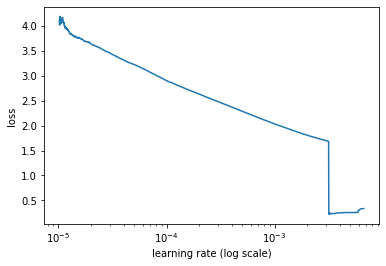

In [ ]:
lr_finder.plot_loss()

In [ ]:
lr_finder.get_best_lr(1)

0.003162277

# Fit one cycle

In [ ]:
"""
https://www.avanwyk.com/tensorflow-2-super-convergence-with-the-1cycle-policy/
"""

class CosineAnnealer:
    def __init__(self, start, end, steps):
        self.start = start
        self.end = end
        self.steps = steps
        self.n = 0
        
    def step(self):
        self.n += 1
        cos = np.cos(np.pi * (self.n / self.steps)) + 1
        return self.end + (self.start - self.end) / 2. * cos


class OneCycleScheduler(tf.keras.callbacks.Callback):
    def __init__(self, lr_max, steps, mom_min=0.85, mom_max=0.95, phase_1_pct=0.3, div_factor=25.):
        super(OneCycleScheduler, self).__init__()
        lr_min = lr_max / div_factor
        final_lr = lr_max / (div_factor * 1e4)
        phase_1_steps = steps * phase_1_pct
        phase_2_steps = steps - phase_1_steps
        
        self.phase_1_steps = phase_1_steps
        self.phase_2_steps = phase_2_steps
        self.phase = 0
        self.step = 0
        
        self.phases = [[CosineAnnealer(lr_min, lr_max, phase_1_steps), CosineAnnealer(mom_max, mom_min, phase_1_steps)], 
                 [CosineAnnealer(lr_max, final_lr, phase_2_steps), CosineAnnealer(mom_min, mom_max, phase_2_steps)]]
        
        self.lrs = []
        self.moms = []

    def on_train_begin(self, logs=None):
        self.phase = 0
        self.step = 0

        self.set_lr(self.lr_schedule().start)
        self.set_momentum(self.mom_schedule().start)
        
    def on_train_batch_begin(self, batch, logs=None):
        self.lrs.append(self.get_lr())
        self.moms.append(self.get_momentum())

    def on_train_batch_end(self, batch, logs=None):
        self.step += 1
        if self.step >= self.phase_1_steps:
            self.phase = 1
            
        self.set_lr(self.lr_schedule().step())
        self.set_momentum(self.mom_schedule().step())
        
    def get_lr(self):
        try:
            return tf.keras.backend.get_value(self.model.optimizer.lr)
        except AttributeError:
            return None
        
    def get_momentum(self):
        try:
            return tf.keras.backend.get_value(self.model.optimizer.momentum)
        except AttributeError:
            return None
        
    def set_lr(self, lr):
        try:
            tf.keras.backend.set_value(self.model.optimizer.lr, lr)
        except AttributeError:
            pass # ignore
        
    def set_momentum(self, mom):
        try:
            tf.keras.backend.set_value(self.model.optimizer.momentum, mom)
        except AttributeError:
            pass # ignore

    def lr_schedule(self):
        return self.phases[self.phase][0]
    
    def mom_schedule(self):
        return self.phases[self.phase][1]
    
    def plot(self):
        ax = plt.subplot(1, 2, 1)
        ax.plot(self.lrs)
        ax.set_title('Learning Rate')
        ax = plt.subplot(1, 2, 2)
        ax.plot(self.moms)
        ax.set_title('Momentum')

In [ ]:
epochs = 30
#lr = lr_finder.get_best_lr(1)
lr = 0.003162277
steps = STEP_SIZE_TRAIN * epochs
lr_schedule = OneCycleScheduler(lr, steps)

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(0.001), loss='binary_crossentropy', metrics=['accuracy'])

model.fit(train_data_iterator, validation_data=validation_data_iterator, epochs=epochs, callbacks=[lr_schedule], verbose=True)

Epoch 1/30
2751/2751 [==============================] - 801s 281ms/step - loss: 3.3479 - accuracy: 0.7691 - val_loss: 3.0273 - val_accuracy: 0.7888
Epoch 2/30
2751/2751 [==============================] - 755s 274ms/step - loss: 3.2289 - accuracy: 0.7753 - val_loss: 3.0673 - val_accuracy: 0.7868
Epoch 3/30
2751/2751 [==============================] - 753s 274ms/step - loss: 3.4025 - accuracy: 0.7653 - val_loss: 3.1915 - val_accuracy: 0.7802
Epoch 4/30
2751/2751 [==============================] - 749s 272ms/step - loss: 3.2324 - accuracy: 0.7763 - val_loss: 3.0379 - val_accuracy: 0.7912
Epoch 5/30
2751/2751 [==============================] - 756s 275ms/step - loss: 3.3805 - accuracy: 0.7703 - val_loss: 2.9872 - val_accuracy: 0.7982
Epoch 6/30
2751/2751 [==============================] - 753s 274ms/step - loss: 3.3093 - accuracy: 0.7768 - val_loss: 3.3475 - val_accuracy: 0.7761
Epoch 7/30
2751/2751 [==============================] - 752s 273ms/step - loss: 3.3492 - accuracy: 0.7755 - val_

### Save model

In [ ]:
model.save('{}/{}'.format(base_dir, 'model.h5'))

# Tensorflow Transfer learning tutorial

## Sans Augmentation

### Create Model

In [ ]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [ ]:
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE, include_top=False, weights='imagenet')

In [ ]:
base_model.trainable = False

In [ ]:
image_batch, label_batch = next(iter(train_data_iterator))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(64, 3, 3, 1280)


In [ ]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(64, 1280)


In [ ]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(64, 1)


In [ ]:
inputs = tf.keras.Input(shape=IMG_SHAPE)
x = preprocess_input(inputs)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [ ]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate), 
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), 
              metrics=['accuracy'])

In [ ]:
len(model.trainable_variables)

2

### Train Model

In [ ]:
initial_epochs = 10

history = model.fit(train_data_iterator, epochs=initial_epochs, validation_data=validation_data_iterator, verbose=True)

Epoch 1/10
2751/2751 [==============================] - 316s 114ms/step - loss: 0.4209 - accuracy: 0.8065 - val_loss: 0.3374 - val_accuracy: 0.8513
Epoch 2/10
2751/2751 [==============================] - 259s 94ms/step - loss: 0.3470 - accuracy: 0.8477 - val_loss: 0.3174 - val_accuracy: 0.8633
Epoch 3/10
2751/2751 [==============================] - 238s 86ms/step - loss: 0.3316 - accuracy: 0.8548 - val_loss: 0.3103 - val_accuracy: 0.8628
Epoch 4/10
2751/2751 [==============================] - 232s 84ms/step - loss: 0.3250 - accuracy: 0.8578 - val_loss: 0.3053 - val_accuracy: 0.8680
Epoch 5/10
2751/2751 [==============================] - 229s 83ms/step - loss: 0.3221 - accuracy: 0.8592 - val_loss: 0.3029 - val_accuracy: 0.8690
Epoch 6/10
2751/2751 [==============================] - 225s 82ms/step - loss: 0.3201 - accuracy: 0.8604 - val_loss: 0.3011 - val_accuracy: 0.8686
Epoch 7/10
2751/2751 [==============================] - 227s 83ms/step - loss: 0.3177 - accuracy: 0.8611 - val_loss: 

In [ ]:
model.save('{}/{}'.format(base_dir, 'mobileNetV2_model0.h5'))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


### Plot loss and accuracy

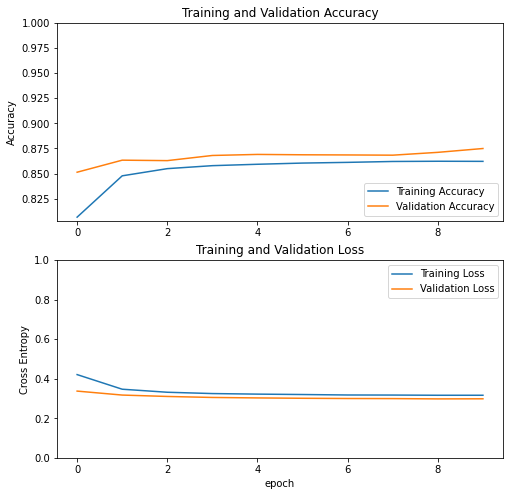

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

### Fine tune model

In [ ]:
base_model.trainable = True

In [ ]:
fine_tune_at = 100

for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), 
              optimizer=tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 96, 96, 3)]       0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 96, 96, 3)         0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 96, 96, 3)         0         
_________________________________________________________________
mobilenetv2_1.00_96 (Functio (None, 3, 3, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1281  

In [ ]:
len(model.trainable_variables)

56

### Train fine tuned model

In [ ]:
fine_tune_epochs = 10
total_epochs = initial_epochs + fine_tune_epochs

history_fine = model.fit(train_data_iterator, 
                         epochs=total_epochs, 
                         initial_epoch=history.epoch[-1], 
                         validation_data=validation_data_iterator)

Epoch 10/20
2751/2751 [==============================] - 258s 91ms/step - loss: 0.2626 - accuracy: 0.8887 - val_loss: 0.2230 - val_accuracy: 0.9074
Epoch 11/20
2751/2751 [==============================] - 249s 90ms/step - loss: 0.2121 - accuracy: 0.9121 - val_loss: 0.2003 - val_accuracy: 0.9192
Epoch 12/20
2751/2751 [==============================] - 246s 89ms/step - loss: 0.1875 - accuracy: 0.9237 - val_loss: 0.1926 - val_accuracy: 0.9196
Epoch 13/20
2751/2751 [==============================] - 248s 90ms/step - loss: 0.1697 - accuracy: 0.9319 - val_loss: 0.1793 - val_accuracy: 0.9292
Epoch 14/20
2751/2751 [==============================] - 246s 89ms/step - loss: 0.1568 - accuracy: 0.9373 - val_loss: 0.1753 - val_accuracy: 0.9350
Epoch 15/20
2751/2751 [==============================] - 247s 90ms/step - loss: 0.1453 - accuracy: 0.9424 - val_loss: 0.1734 - val_accuracy: 0.9287
Epoch 16/20
2751/2751 [==============================] - 245s 89ms/step - loss: 0.1347 - accuracy: 0.9478 - val_

### Plot improved loss and accuracy

In [ ]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

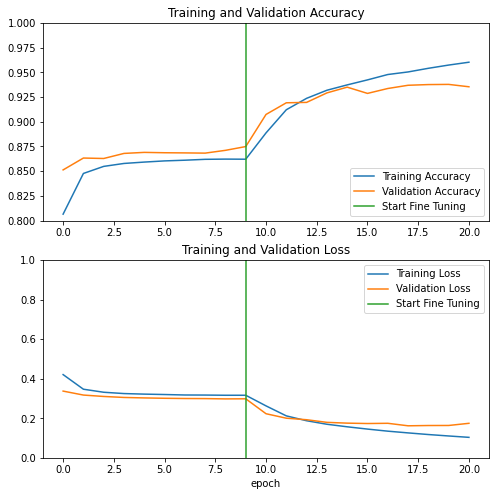

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
model.save('{}/{}'.format(base_dir, 'mobileNetV2_model_tuned.h5'))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


## Data Augmentation (with replacement)

### Create Model

In [ ]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [ ]:
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE, include_top=False, weights='imagenet')

In [ ]:
base_model.trainable = False

In [ ]:
image_batch, label_batch = next(iter(train_data_iterator))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(64, 3, 3, 1280)


In [ ]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(64, 1280)


In [ ]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(64, 1)


In [ ]:
inputs = tf.keras.Input(shape=IMG_SHAPE)
x = preprocess_input(inputs)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(1)(x)
#outputs = prediction_layer(x)
model = tf.keras.Model(inputs, x)

In [ ]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 96, 96, 3)]       0         
_________________________________________________________________
tf.math.truediv_1 (TFOpLambd (None, 96, 96, 3)         0         
_________________________________________________________________
tf.math.subtract_1 (TFOpLamb (None, 96, 96, 3)         0         
_________________________________________________________________
mobilenetv2_1.00_96 (Functio (None, 3, 3, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1280)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 1281

In [ ]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate), 
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), 
              metrics=['accuracy'])

In [ ]:
len(model.trainable_variables)

2

### Train Model

In [ ]:
initial_epochs = 10

history = model.fit(train_data_iterator, epochs=initial_epochs, validation_data=validation_data_iterator, verbose=True)

Epoch 1/10
2751/2751 [==============================] - 339s 122ms/step - loss: 0.4344 - accuracy: 0.7943 - val_loss: 0.3559 - val_accuracy: 0.8405
Epoch 2/10
2751/2751 [==============================] - 327s 119ms/step - loss: 0.3662 - accuracy: 0.8350 - val_loss: 0.3381 - val_accuracy: 0.8537
Epoch 3/10
2751/2751 [==============================] - 317s 115ms/step - loss: 0.3517 - accuracy: 0.8419 - val_loss: 0.3296 - val_accuracy: 0.8570
Epoch 4/10
2751/2751 [==============================] - 315s 114ms/step - loss: 0.3445 - accuracy: 0.8466 - val_loss: 0.3255 - val_accuracy: 0.8540
Epoch 5/10
2751/2751 [==============================] - 317s 115ms/step - loss: 0.3409 - accuracy: 0.8475 - val_loss: 0.3226 - val_accuracy: 0.8574
Epoch 6/10
2751/2751 [==============================] - 317s 115ms/step - loss: 0.3399 - accuracy: 0.8489 - val_loss: 0.3228 - val_accuracy: 0.8563
Epoch 7/10
2751/2751 [==============================] - 315s 114ms/step - loss: 0.3390 - accuracy: 0.8494 - val_

In [ ]:
model.save('{}/{}'.format(base_dir, 'mobileNetV2_model_dataAug.h5'))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


### Plot loss and accuracy

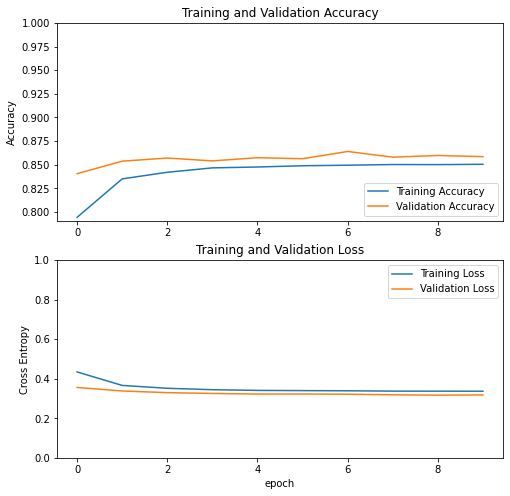

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

### Fine tune model

In [ ]:
base_model.trainable = True

In [ ]:
fine_tune_at = 100

for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), 
              optimizer=tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 96, 96, 3)]       0         
_________________________________________________________________
tf.math.truediv_1 (TFOpLambd (None, 96, 96, 3)         0         
_________________________________________________________________
tf.math.subtract_1 (TFOpLamb (None, 96, 96, 3)         0         
_________________________________________________________________
mobilenetv2_1.00_96 (Functio (None, 3, 3, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1280)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 1281

In [ ]:
len(model.trainable_variables)

56

### Train fine tuned model

In [ ]:
fine_tune_epochs = 10
total_epochs = initial_epochs + fine_tune_epochs

history_fine = model.fit(train_data_iterator, 
                         epochs=total_epochs, 
                         initial_epoch=history.epoch[-1], 
                         validation_data=validation_data_iterator)

Epoch 10/20
2751/2751 [==============================] - 356s 123ms/step - loss: 0.2826 - accuracy: 0.8791 - val_loss: 0.2433 - val_accuracy: 0.8920
Epoch 11/20
2751/2751 [==============================] - 331s 120ms/step - loss: 0.2362 - accuracy: 0.9011 - val_loss: 0.2231 - val_accuracy: 0.9028
Epoch 12/20
2751/2751 [==============================] - 329s 120ms/step - loss: 0.2164 - accuracy: 0.9107 - val_loss: 0.2126 - val_accuracy: 0.9190
Epoch 13/20
2751/2751 [==============================] - 332s 121ms/step - loss: 0.2036 - accuracy: 0.9174 - val_loss: 0.2162 - val_accuracy: 0.9204
Epoch 14/20
2751/2751 [==============================] - 330s 120ms/step - loss: 0.1947 - accuracy: 0.9212 - val_loss: 0.1944 - val_accuracy: 0.9217
Epoch 15/20
2751/2751 [==============================] - 333s 121ms/step - loss: 0.1879 - accuracy: 0.9242 - val_loss: 0.1864 - val_accuracy: 0.9263
Epoch 16/20
2751/2751 [==============================] - 332s 121ms/step - loss: 0.1822 - accuracy: 0.9272

### Plot improved loss and accuracy

In [ ]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

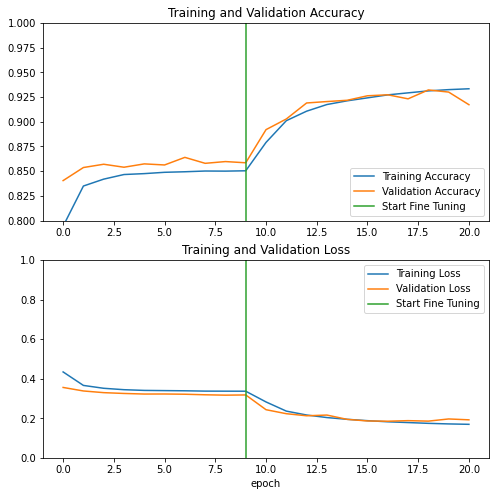

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
model.save('{}/{}'.format(base_dir, 'mobileNetV2_model_dataAug_tuned.h5'))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


## Data Augmentation (with image generation)

### Generate additional images

In [ ]:
aug = ImageDataGenerator(brightness_range=[0.3, 1], 
                         horizontal_flip=True, 
                         vertical_flip=True, 
                         channel_shift_range=150)

In [ ]:
folders = ['train']#, 'test']
labels = ['0', '1']
# provide degree of data expansion required, 1x, 2x, 1.5x, 0.5x
p = 1.5 #not used currently due to uncertain behaviour of imagedatagenerator

In [ ]:
for folder in folders:
    df = pd.read_csv('{}_labels.csv'.format(folder))
    for filename, label in zip(df['id'], df['label']):
        image = tf.keras.preprocessing.image.load_img('{}/{}/{}/{}.tif'.format('dataset_folder', folder, label, filename))
        image = tf.keras.preprocessing.image.img_to_array(image)
        image = np.expand_dims(image, axis=0)
        for x, var in zip(aug.flow(image, batch_size=1, save_to_dir='{}/{}/{}/'.format('dataset_folder', folder, label), save_prefix='aug_{}'.format(filename), save_format='tif'), range(0)):
            pass
        #imageGen = aug.flow(image, batch_size=1, save_to_dir='{}/{}/{}/'.format('test_folder', folder, label), save_prefix='aug_{}'.format(filename), save_format='tif')

        """for itr in range(int(p)):
          next(imageGen)"""
        """
        if random.random() < (p -  int(p)):
          next(imageGen)
        """

In [ ]:
#!find dataset_folder/train/0/ -name '*.tiff' -type f -delete
#!find dataset_folder/train/1/ -name '*.tiff' -type f -delete

### Create data generators

In [ ]:
new_base_dir = 'dataset_folder'
training_sub_path = 'train'
test_sub_path = 'test'

In [ ]:
IMG_SIZE = (96, 96) 
IMG_SHAPE = IMG_SIZE + (3,)
BATCH_SIZE = 64

In [ ]:
data_generator = ImageDataGenerator(validation_split=0.2)

In [ ]:
train_data_iterator = data_generator.flow_from_directory('{}/{}'.format(new_base_dir, 'train'), 
                                                         target_size=IMG_SIZE,
                                                         class_mode='binary', 
                                                         subset='training', 
                                                         batch_size=BATCH_SIZE)

Found 352041 images belonging to 2 classes.


In [ ]:
validation_data_iterator = data_generator.flow_from_directory('{}/{}'.format(new_base_dir, 'train'), 
                                                              target_size=IMG_SIZE,
                                                              class_mode='binary', 
                                                              subset='validation', 
                                                              batch_size=BATCH_SIZE)

Found 88009 images belonging to 2 classes.


In [ ]:
STEP_SIZE_TRAIN = train_data_iterator.n//train_data_iterator.batch_size
STEP_SIZE_VALIDATION = validation_data_iterator.n//validation_data_iterator.batch_size

### Create Model

In [ ]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [ ]:
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE, include_top=False, weights='imagenet')

9412608/9406464 [==============================] - 0s 0us/step


In [ ]:
base_model.trainable = False

In [ ]:
image_batch, label_batch = next(iter(train_data_iterator))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(64, 3, 3, 1280)


In [ ]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(64, 1280)


In [ ]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(64, 1)


In [ ]:
inputs = tf.keras.Input(shape=IMG_SHAPE)
x = preprocess_input(inputs)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(1)(x)
#outputs = prediction_layer(x)
model = tf.keras.Model(inputs, x)

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 96, 96, 3)]       0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 96, 96, 3)         0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 96, 96, 3)         0         
_________________________________________________________________
mobilenetv2_1.00_96 (Functio (None, 3, 3, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 1281  

In [ ]:
base_learning_rate = 0.0001

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate), 
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), 
              metrics=['accuracy'])

In [ ]:
len(model.trainable_variables)

2

### Train Model

In [ ]:
initial_epochs = 10

In [ ]:
history = model.fit(train_data_iterator, epochs=initial_epochs, validation_data=validation_data_iterator, verbose=True)

Epoch 1/10
5501/5501 [==============================] - 863s 156ms/step - loss: 0.4220 - accuracy: 0.8064 - val_loss: 0.3362 - val_accuracy: 0.8549
Epoch 2/10
5501/5501 [==============================] - 810s 147ms/step - loss: 0.3644 - accuracy: 0.8365 - val_loss: 0.3290 - val_accuracy: 0.8623
Epoch 3/10
5501/5501 [==============================] - 789s 143ms/step - loss: 0.3565 - accuracy: 0.8408 - val_loss: 0.3203 - val_accuracy: 0.8613
Epoch 4/10
5501/5501 [==============================] - 795s 144ms/step - loss: 0.3547 - accuracy: 0.8410 - val_loss: 0.3182 - val_accuracy: 0.8577
Epoch 5/10
5501/5501 [==============================] - 799s 145ms/step - loss: 0.3531 - accuracy: 0.8428 - val_loss: 0.3175 - val_accuracy: 0.8640
Epoch 6/10
5501/5501 [==============================] - 788s 143ms/step - loss: 0.3524 - accuracy: 0.8425 - val_loss: 0.3156 - val_accuracy: 0.8608
Epoch 7/10
5501/5501 [==============================] - 779s 142ms/step - loss: 0.3518 - accuracy: 0.8431 - val_

In [ ]:
model.save('{}/{}'.format(base_dir, 'mobileNetV2_model_dataGen.h5'))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [ ]:
model = tf.keras.models.load_model('{}/{}'.format(base_dir, 'mobileNetV2_model_dataGen.h5'))

### Plot loss and accuracy

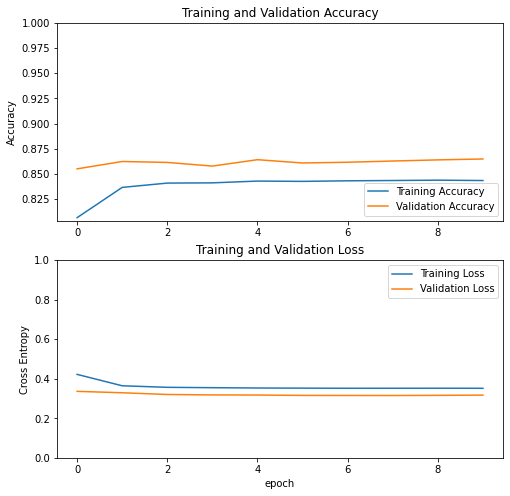

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

### Fine tune model

In [ ]:
base_model.trainable = True

In [ ]:
fine_tune_at = 100

for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), 
              optimizer=tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 96, 96, 3)]       0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 96, 96, 3)         0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 96, 96, 3)         0         
_________________________________________________________________
mobilenetv2_1.00_96 (Functio (None, 3, 3, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 1281  

In [ ]:
len(model.trainable_variables)

56

### Train fine tuned model

In [ ]:
fine_tune_epochs = 10
total_epochs = initial_epochs + fine_tune_epochs

history_fine = model.fit(train_data_iterator, 
                         epochs=total_epochs, 
                         initial_epoch=history.epoch[-1], 
                         validation_data=validation_data_iterator)

Epoch 11/20
5501/5501 [==============================] - 825s 149ms/step - loss: 0.2808 - accuracy: 0.8788 - val_loss: 0.2150 - val_accuracy: 0.9068
Epoch 12/20
5501/5501 [==============================] - 812s 148ms/step - loss: 0.2310 - accuracy: 0.9038 - val_loss: 0.1890 - val_accuracy: 0.9233
Epoch 13/20
5501/5501 [==============================] - 802s 146ms/step - loss: 0.2097 - accuracy: 0.9140 - val_loss: 0.1896 - val_accuracy: 0.9293
Epoch 14/20
5501/5501 [==============================] - 795s 145ms/step - loss: 0.1969 - accuracy: 0.9201 - val_loss: 0.1758 - val_accuracy: 0.9276
Epoch 15/20
5501/5501 [==============================] - 791s 144ms/step - loss: 0.1875 - accuracy: 0.9245 - val_loss: 0.1680 - val_accuracy: 0.9322
Epoch 16/20
5501/5501 [==============================] - 800s 145ms/step - loss: 0.1801 - accuracy: 0.9278 - val_loss: 0.1762 - val_accuracy: 0.9393
Epoch 17/20
5501/5501 [==============================] - 793s 144ms/step - loss: 0.1747 - accuracy: 0.9305

### Plot improved loss and accuracy

In [ ]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

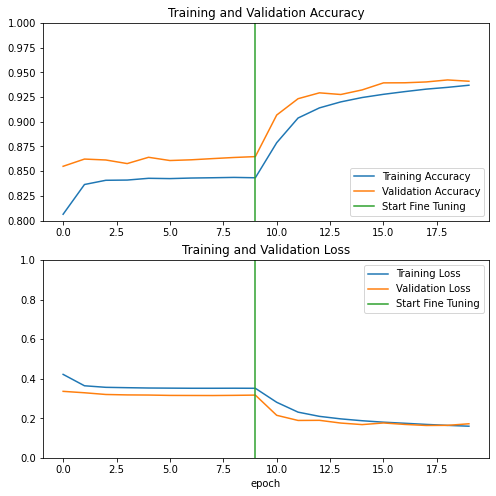

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
model.save('{}/{}'.format(base_dir, 'mobileNetV2_model_dataGen_tuned.h5'))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


## One Cycle policy

### One cycle scheduler

In [ ]:
"""
https://www.avanwyk.com/tensorflow-2-super-convergence-with-the-1cycle-policy/
"""

class CosineAnnealer:
    def __init__(self, start, end, steps):
        self.start = start
        self.end = end
        self.steps = steps
        self.n = 0
        
    def step(self):
        self.n += 1
        cos = np.cos(np.pi * (self.n / self.steps)) + 1
        return self.end + (self.start - self.end) / 2. * cos


class OneCycleScheduler(tf.keras.callbacks.Callback):
    def __init__(self, lr_max, steps, mom_min=0.85, mom_max=0.95, phase_1_pct=0.3, div_factor=25.):
        super(OneCycleScheduler, self).__init__()
        lr_min = lr_max / div_factor
        final_lr = lr_max / (div_factor * 1e4)
        phase_1_steps = steps * phase_1_pct
        phase_2_steps = steps - phase_1_steps
        
        self.phase_1_steps = phase_1_steps
        self.phase_2_steps = phase_2_steps
        self.phase = 0
        self.step = 0
        
        self.phases = [[CosineAnnealer(lr_min, lr_max, phase_1_steps), CosineAnnealer(mom_max, mom_min, phase_1_steps)], 
                 [CosineAnnealer(lr_max, final_lr, phase_2_steps), CosineAnnealer(mom_min, mom_max, phase_2_steps)]]
        
        self.lrs = []
        self.moms = []

    def on_train_begin(self, logs=None):
        self.phase = 0
        self.step = 0

        self.set_lr(self.lr_schedule().start)
        self.set_momentum(self.mom_schedule().start)
        
    def on_train_batch_begin(self, batch, logs=None):
        self.lrs.append(self.get_lr())
        self.moms.append(self.get_momentum())

    def on_train_batch_end(self, batch, logs=None):
        self.step += 1
        if self.step >= self.phase_1_steps:
            self.phase = 1
            
        self.set_lr(self.lr_schedule().step())
        self.set_momentum(self.mom_schedule().step())
        
    def get_lr(self):
        try:
            return tf.keras.backend.get_value(self.model.optimizer.lr)
        except AttributeError:
            return None
        
    def get_momentum(self):
        try:
            return tf.keras.backend.get_value(self.model.optimizer.momentum)
        except AttributeError:
            return None
        
    def set_lr(self, lr):
        try:
            tf.keras.backend.set_value(self.model.optimizer.lr, lr)
        except AttributeError:
            pass # ignore
        
    def set_momentum(self, mom):
        try:
            tf.keras.backend.set_value(self.model.optimizer.momentum, mom)
        except AttributeError:
            pass # ignore

    def lr_schedule(self):
        return self.phases[self.phase][0]
    
    def mom_schedule(self):
        return self.phases[self.phase][1]
    
    def plot(self):
        ax = plt.subplot(1, 2, 1)
        ax.plot(self.lrs)
        ax.set_title('Learning Rate')
        ax = plt.subplot(1, 2, 2)
        ax.plot(self.moms)
        ax.set_title('Momentum')

### Create data generators

In [ ]:
new_base_dir = 'dataset_folder'
training_sub_path = 'train'
test_sub_path = 'test'

In [ ]:
IMG_SIZE = (96, 96) 
IMG_SHAPE = IMG_SIZE + (3,)
BATCH_SIZE = 64

In [ ]:
data_generator = ImageDataGenerator(validation_split=0.2)

In [ ]:
train_data_iterator = data_generator.flow_from_directory('{}/{}'.format(new_base_dir, 'train'), 
                                                         target_size=IMG_SIZE,
                                                         class_mode='binary', 
                                                         subset='training', 
                                                         batch_size=BATCH_SIZE)

Found 352041 images belonging to 2 classes.


In [ ]:
validation_data_iterator = data_generator.flow_from_directory('{}/{}'.format(new_base_dir, 'train'), 
                                                              target_size=IMG_SIZE,
                                                              class_mode='binary', 
                                                              subset='validation', 
                                                              batch_size=BATCH_SIZE)

Found 88009 images belonging to 2 classes.


In [ ]:
STEP_SIZE_TRAIN = train_data_iterator.n//train_data_iterator.batch_size
STEP_SIZE_VALIDATION = validation_data_iterator.n//validation_data_iterator.batch_size

### Create Model

In [ ]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [ ]:
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE, include_top=False, weights='imagenet')

9412608/9406464 [==============================] - 0s 0us/step


In [ ]:
base_model.trainable = False

In [ ]:
image_batch, label_batch = next(iter(train_data_iterator))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(64, 3, 3, 1280)


In [ ]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(64, 1280)


In [ ]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(64, 1)


In [ ]:
inputs = tf.keras.Input(shape=IMG_SHAPE)
x = preprocess_input(inputs)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(1)(x)
model = tf.keras.Model(inputs, x)

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 96, 96, 3)]       0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 96, 96, 3)         0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 96, 96, 3)         0         
_________________________________________________________________
mobilenetv2_1.00_96 (Functio (None, 3, 3, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 1281  

In [ ]:
base_learning_rate = 0.0001

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate), 
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), 
              metrics=['accuracy'])

In [ ]:
len(model.trainable_variables)

2

### Train Model

In [ ]:
initial_epochs = 10
steps = STEP_SIZE_TRAIN * initial_epochs
lr_schedule = OneCycleScheduler(base_learning_rate, steps)

In [ ]:
history = model.fit(train_data_iterator, 
                    epochs=initial_epochs, 
                    validation_data=validation_data_iterator, 
                    callbacks=[lr_schedule], 
                    verbose=True)

model.save('{}/{}'.format(base_dir, 'mobileNetV2_model_onecycle.h5'))

Epoch 1/10
5501/5501 [==============================] - 863s 156ms/step - loss: 0.4220 - accuracy: 0.8064 - val_loss: 0.3362 - val_accuracy: 0.8549
Epoch 2/10
5501/5501 [==============================] - 810s 147ms/step - loss: 0.3644 - accuracy: 0.8365 - val_loss: 0.3290 - val_accuracy: 0.8623
Epoch 3/10
5501/5501 [==============================] - 789s 143ms/step - loss: 0.3565 - accuracy: 0.8408 - val_loss: 0.3203 - val_accuracy: 0.8613
Epoch 4/10
5501/5501 [==============================] - 795s 144ms/step - loss: 0.3547 - accuracy: 0.8410 - val_loss: 0.3182 - val_accuracy: 0.8577
Epoch 5/10
5501/5501 [==============================] - 799s 145ms/step - loss: 0.3531 - accuracy: 0.8428 - val_loss: 0.3175 - val_accuracy: 0.8640
Epoch 6/10
5501/5501 [==============================] - 788s 143ms/step - loss: 0.3524 - accuracy: 0.8425 - val_loss: 0.3156 - val_accuracy: 0.8608
Epoch 7/10
5501/5501 [==============================] - 779s 142ms/step - loss: 0.3518 - accuracy: 0.8431 - val_

In [ ]:
model = tf.keras.models.load_model('{}/{}'.format(base_dir, 'mobileNetV2_model_onecycle.h5'))

### Plot loss and accuracy

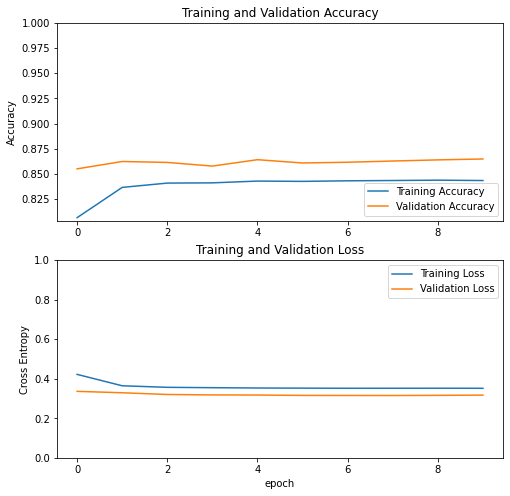

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

### Fine tune model

In [ ]:
base_model.trainable = True

In [ ]:
fine_tune_at = 100

for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), 
              optimizer=tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 96, 96, 3)]       0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 96, 96, 3)         0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 96, 96, 3)         0         
_________________________________________________________________
mobilenetv2_1.00_96 (Functio (None, 3, 3, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 1281  

In [ ]:
len(model.trainable_variables)

56

### Train fine tuned model

In [ ]:
fine_tune_epochs = 10
total_epochs = initial_epochs + fine_tune_epochs

history_fine = model.fit(train_data_iterator, 
                         epochs=total_epochs, 
                         initial_epoch=history.epoch[-1], 
                         validation_data=validation_data_iterator)

model.save('{}/{}'.format(base_dir, 'mobileNetV2_model_onecycle_tune.h5'))

Epoch 11/20
5501/5501 [==============================] - 825s 149ms/step - loss: 0.2808 - accuracy: 0.8788 - val_loss: 0.2150 - val_accuracy: 0.9068
Epoch 12/20
5501/5501 [==============================] - 812s 148ms/step - loss: 0.2310 - accuracy: 0.9038 - val_loss: 0.1890 - val_accuracy: 0.9233
Epoch 13/20
5501/5501 [==============================] - 802s 146ms/step - loss: 0.2097 - accuracy: 0.9140 - val_loss: 0.1896 - val_accuracy: 0.9293
Epoch 14/20
5501/5501 [==============================] - 795s 145ms/step - loss: 0.1969 - accuracy: 0.9201 - val_loss: 0.1758 - val_accuracy: 0.9276
Epoch 15/20
5501/5501 [==============================] - 791s 144ms/step - loss: 0.1875 - accuracy: 0.9245 - val_loss: 0.1680 - val_accuracy: 0.9322
Epoch 16/20
5501/5501 [==============================] - ETA: 0s - loss: 0.1801 - accuracy: 0.9278

### Plot improved loss and accuracy

In [ ]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

# References

  * https://github.com/priya-dwivedi/Deep-Learning/blob/master/resnet_keras/Residual_Networks_yourself.ipynb